# Perceptual Framing Analysis Script (Perceptual Experiment)
# GLAM model estimation
------------------

In [1]:
import glam
import pandas as pd
import numpy as np
import os.path
import seaborn as sns
import arviz as az

import matplotlib.pyplot as plt

/Users/pradyumna/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/pradyumna/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import pymc3 as pm

In [3]:
np.random.seed(23) # from random.org

In [4]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

# Individual GLAM estimation and out of sample prediction (Less Inv)

## Load data

In [5]:
# Load data
sufix = '_individual_Less_Inv_NoBin_excludedTrial_Gamma-11_NUTS_32_eLife'
data = pd.read_csv('data/PF2019_data/GlamDataPF2019_Less_Inv_NoBin_33.csv')

## Reaction times for each participant

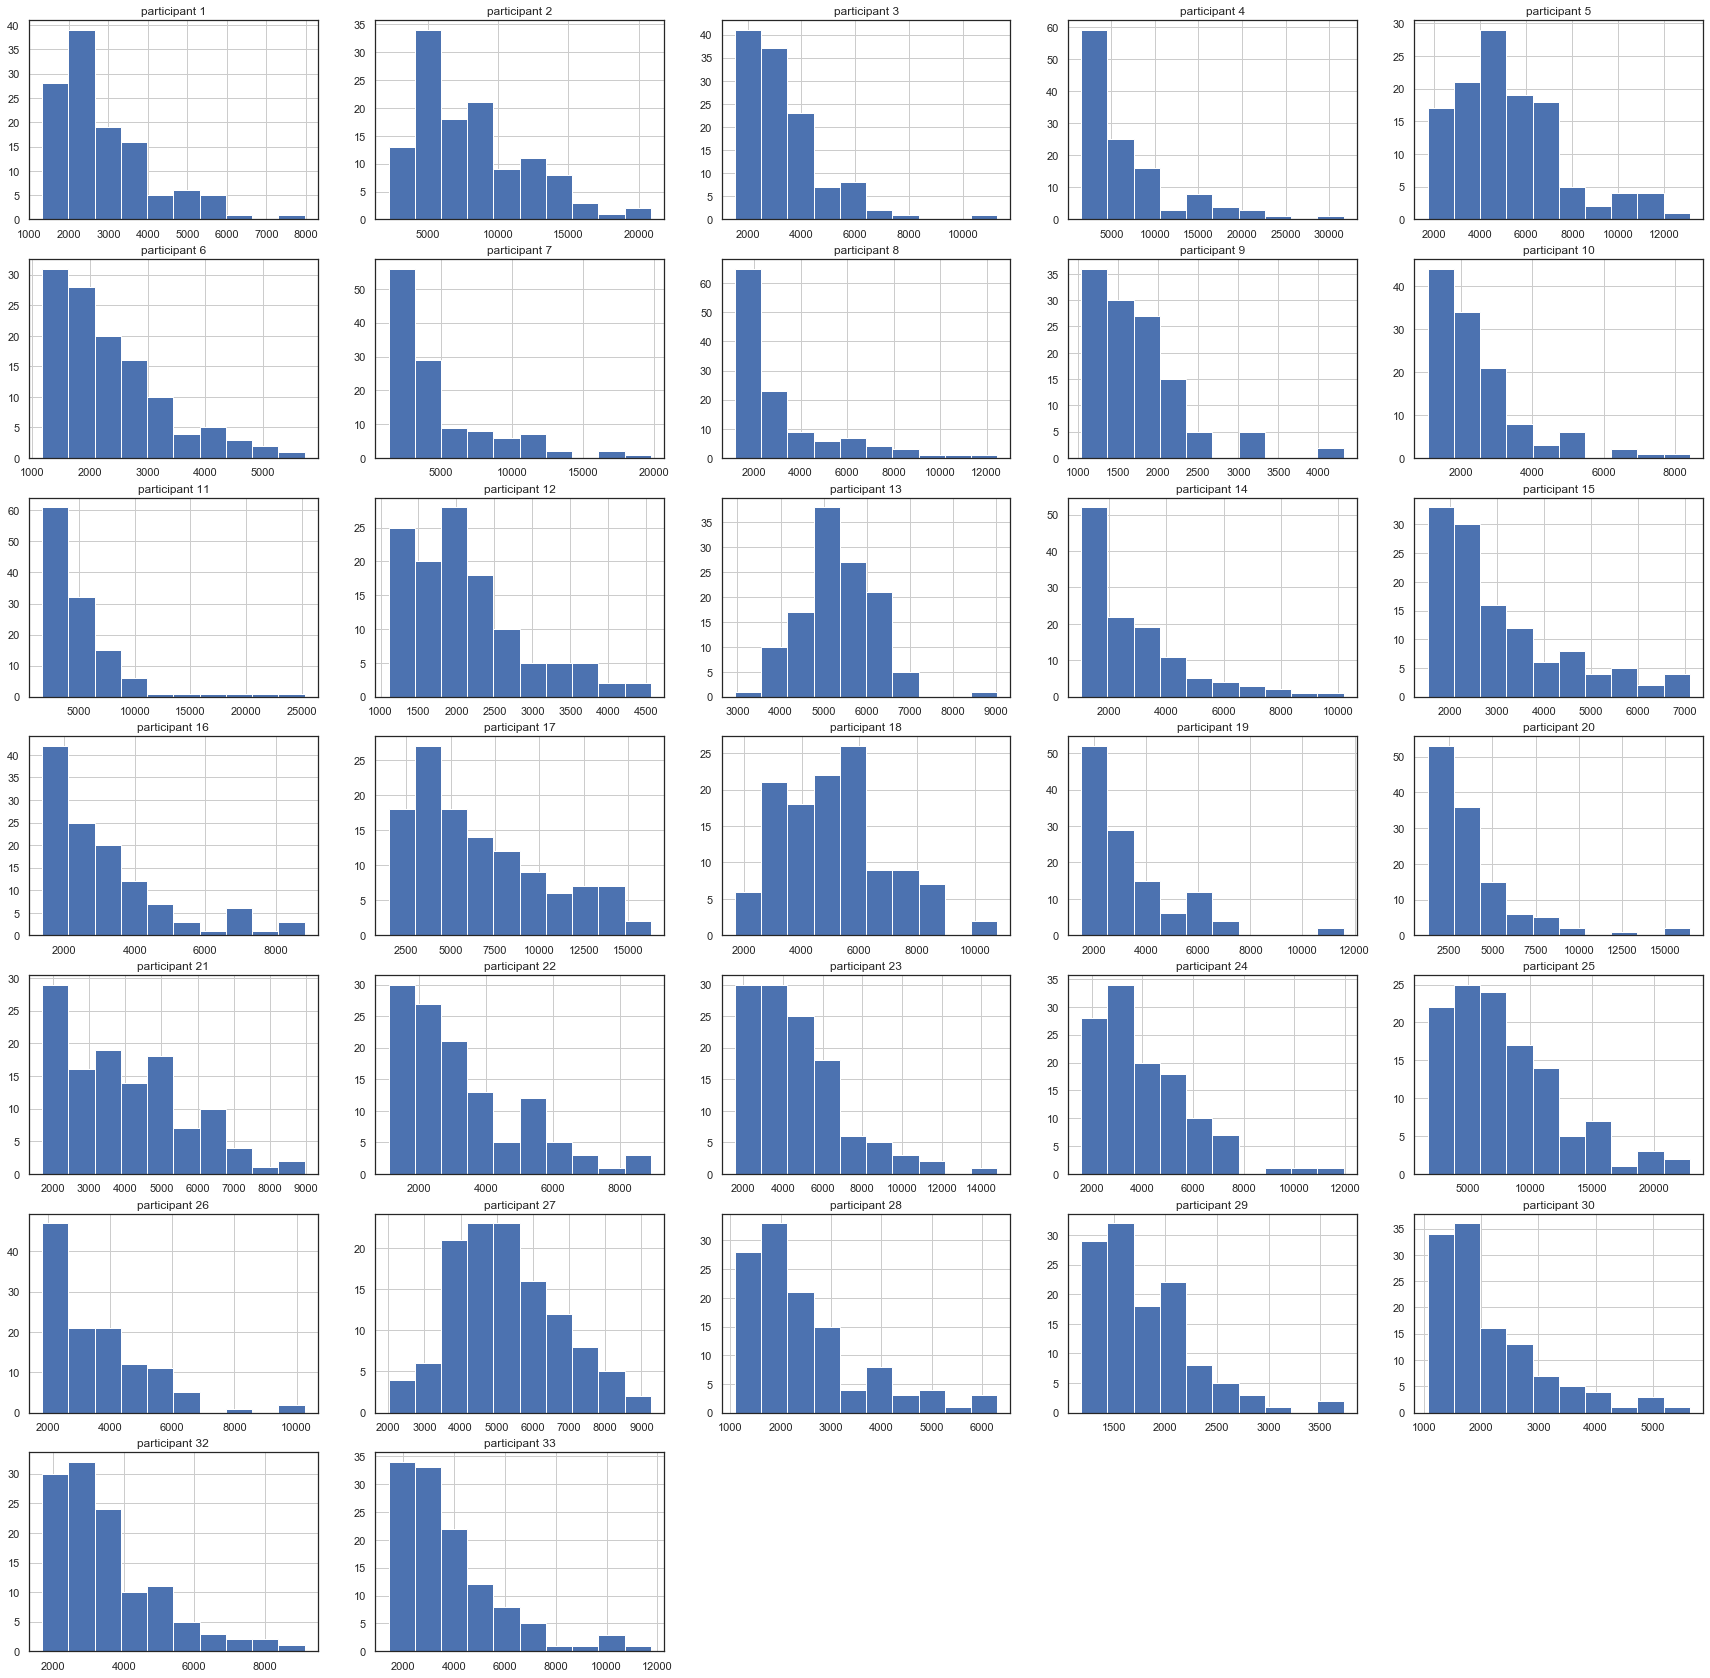

In [6]:
participants = data.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data[(data.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1


In [7]:
data["zrt"] = z_score1(data,'subject',"rt")

## Remove outliers RT

In [8]:
# remove outliers (two criteria)
data1 = data[(data.zrt <= 3) ]
data1 = data1[(data1.rt <= 20000) ]

In [9]:
#participants = data.subject.unique()
#f = plt.figure(figsize=(30,30))
#order = 1
#sns.set_style('white')

#for i in data.subject.unique():
#    sub={}
#    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
#    sub['%s' % i].plot()    
#    data[(data.subject == i)].zrt.hist()
#    sub['%s' % i].set_title('participant %s' % i)
#    order += 1

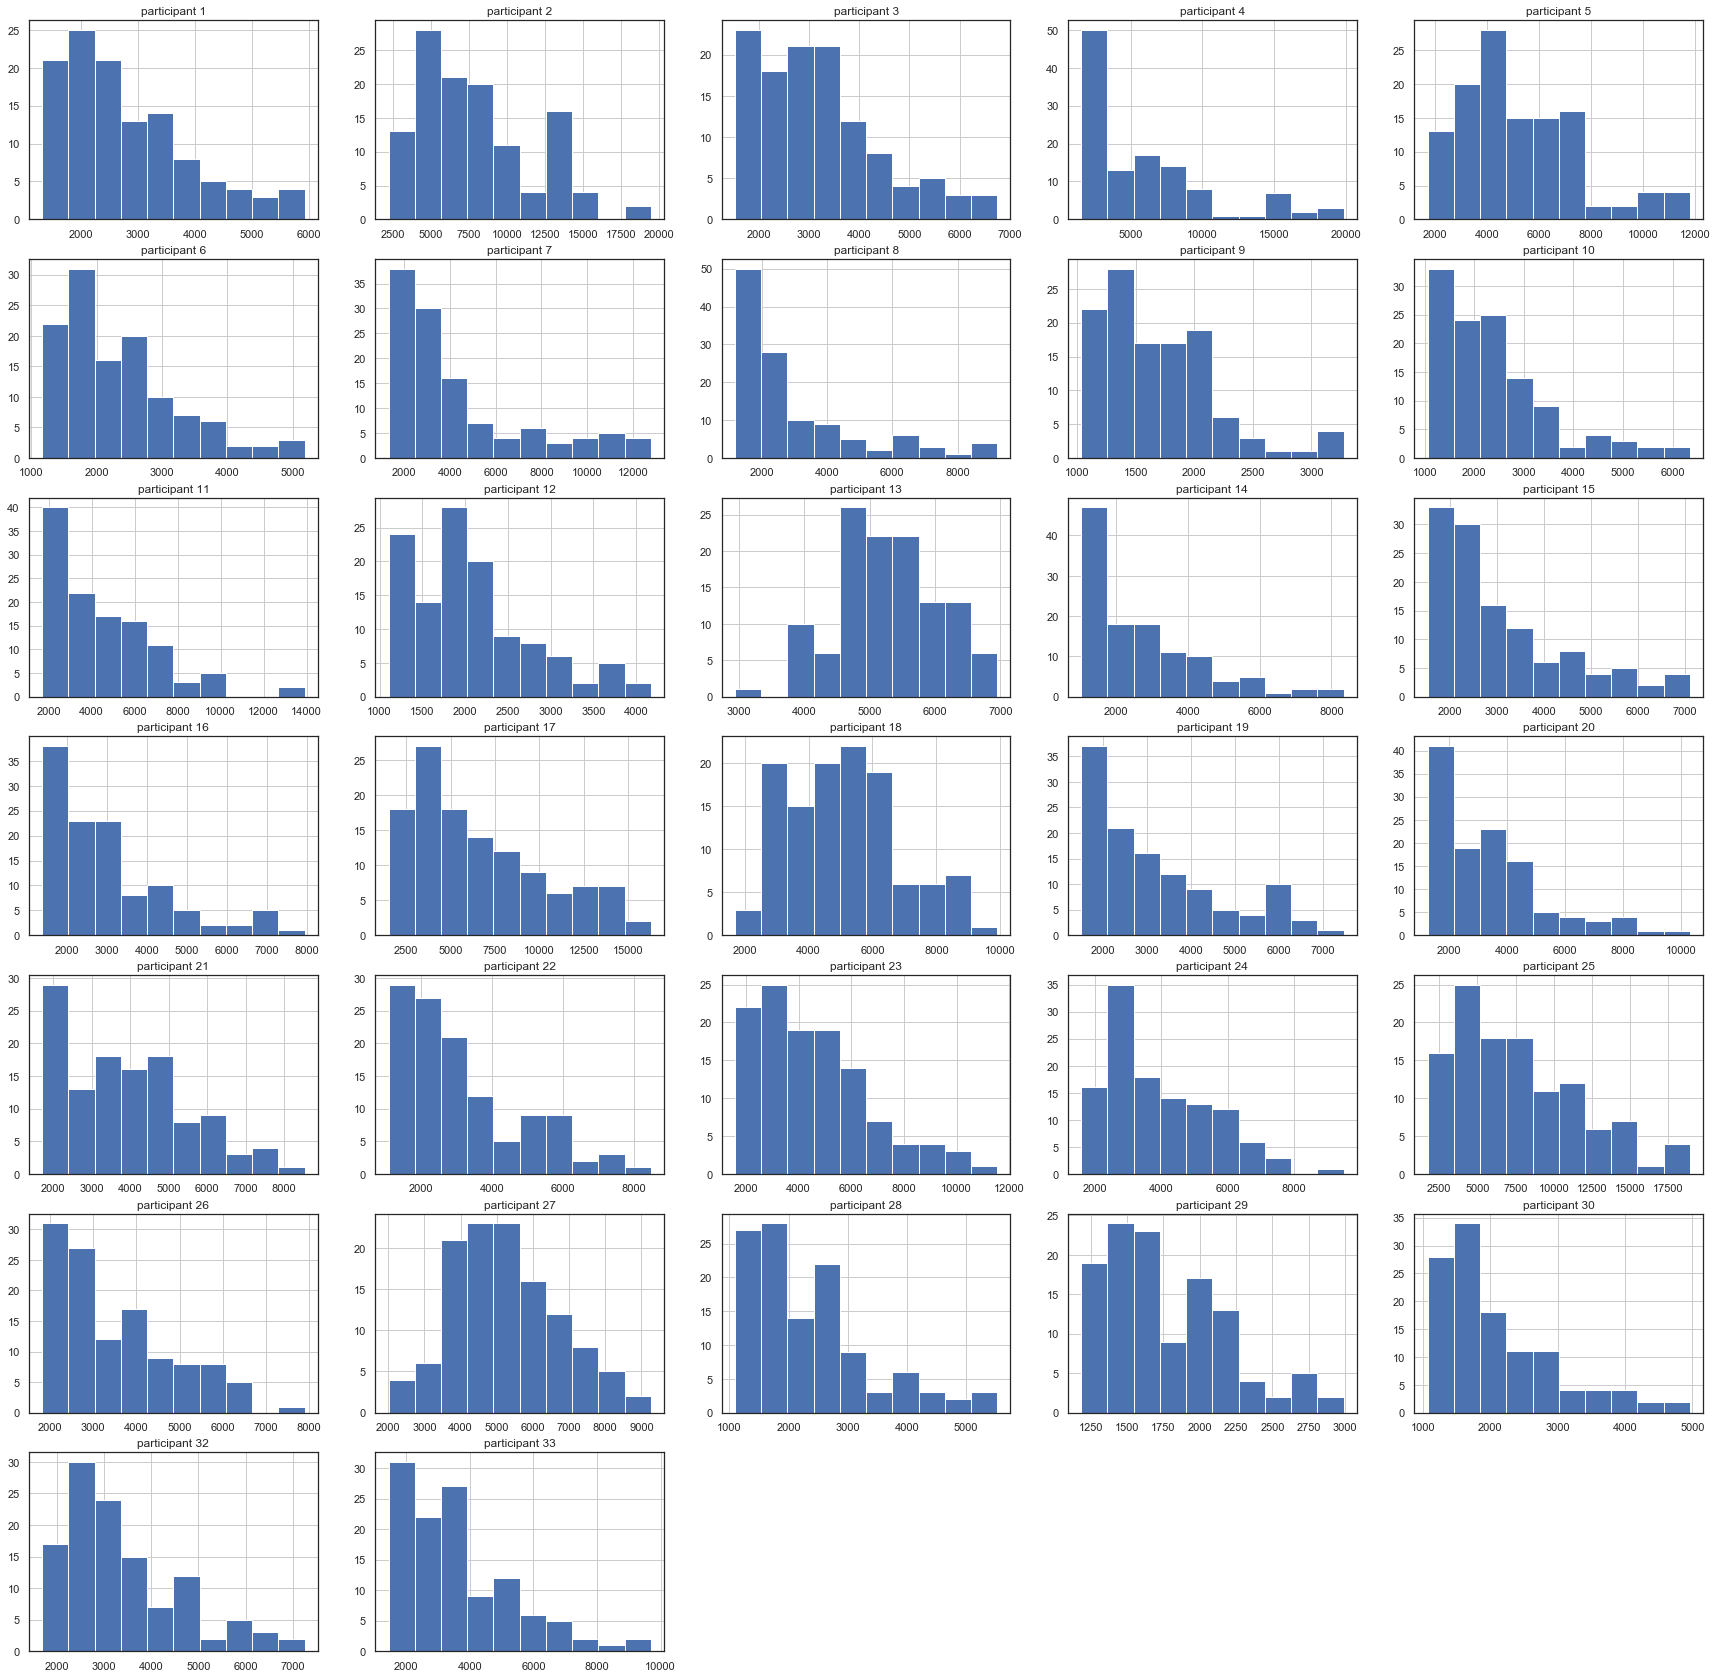

In [10]:
participants = data1.subject.unique()
f = plt.figure(figsize=(30,30))
order = 1
sns.set_style('white')

for i in data1.subject.unique():
    sub={}
    sub['%s' % i] = plt.subplot(int(len(participants)/5+1), 5, order)
    sub['%s' % i].plot()    
    data1[(data1.subject == i)].rt.hist()
    sub['%s' % i].set_title('participant %s' % i)
    order += 1

# Subset only necessary columns


In [11]:
# Subset only necessary columns
data = data1[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,1,0,0,4261.735,63,42,0.603448,0.396552
1,1,1,1,3559.258,126,123,0.490772,0.509228
2,1,2,1,3754.464,123,129,0.490893,0.509107
3,1,3,0,2431.751,116,123,0.639125,0.360875
4,1,4,0,2199.342,131,123,0.702232,0.297768


# participants removed from GLAM analysis

In [12]:
data = data[ (data['subject'] != 1) & (data['subject'] != 13) & (data['subject'] != 16) & (data['subject'] != 20)]


## Split data in training and test sets

In [13]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

#test_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_test'+sufix+'.csv'))
#train_data.to_csv(str('data/PF2019_data/GlamDataPF2019_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1658 trials) and test (1649 trials) sets...


## Individual GLAM estimation

### 1. full GLAM

In [14]:
# Fitting full GLAM
print('Fitting full GLAM individually...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_PF2019_full'+sufix+'.npy')):
    glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='NUTS', tune=1000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_PF2019_full'+sufix+'.npy'))   

Fitting full GLAM individually...
Generating single subject models for 28 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 28 model(s) using NUTS...
  Fitting model 1 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6657742376909012, but should be close to 0.8. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 2 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 410 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6827791346845875, but should be close to 0.8. Try to increase the number of tuning steps.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6716007719251329, but should be close to 0.8. Try to increase the number of tuning steps.
There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5958506303291323, but should be close to 0.8. Try to increase the number of tuning steps.
There were 397 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6841812250385578, but should be close 

  Fitting model 3 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 4 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 5 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 6 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7040983480669658, but should be close to 0.8. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6885965788580791, but should be close to 0.8. Try to increase the number of tuning steps.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7121042355368572, but should be close to 0.8. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS

  Fitting model 7 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9049408877284247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5286417688482539, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 8 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5854205603172187, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6191377882284376, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 9 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.7174272913709301, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 10 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 11 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 263 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


  Fitting model 12 of 28...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, SNR, gamma, v]


ValueError: Not enough samples to build a trace.

In [ ]:
# Save parameter estimates
np.save(str('results/estimates/glam_PF2019_full'+sufix+'.npy'), glam_full.estimates)
pd.DataFrame(glam_full.estimates)

In [ ]:
# Estimate Convergence

rhat_gamma =[] 
rhat_v = []
rhat_tau =[] 
rhat_s =[] 

ess_gamma =[] 
ess_v = []
ess_tau =[] 
ess_s =[] 

part_num =  []
for i in range(len(glam_full.trace)):
    model_trace = glam_full.trace[i]
    # estimate rhat param
    rhats_params = az.rhat(model_trace, method="folded")
    rhat_gamma.append(rhats_params.gamma.values)
    rhat_v.append(rhats_params.v.values)
    rhat_tau.append(rhats_params.tau.values)
    rhat_s.append(rhats_params.s.values)
    part_num.append(i)

    # estimate effective sample size
    ess_model = az.ess(model_trace, relative=False)
    ess_gamma.append(ess_model.gamma.values)
    ess_v.append(ess_model.v.values)
    ess_tau.append(ess_model.tau.values)
    ess_s.append(ess_model.s.values)
    
rhats_params_df = pd.DataFrame()
rhats_params_df['gamma'] = rhat_gamma
rhats_params_df['v'] = rhat_v
rhats_params_df['tau'] = rhat_tau
rhats_params_df['s'] = rhat_s
rhats_params_df['part'] = part_num

ess_params_df = pd.DataFrame()
ess_params_df['gamma'] = ess_gamma
ess_params_df['v'] = ess_v
ess_params_df['tau'] = ess_tau
ess_params_df['s'] = ess_s
    

In [ ]:
1-rhats_params_df

In [ ]:
ess_params_df

In [ ]:
# Compute WAICs
print('Computing WAIC scores for full model...')
if not os.path.exists(str('results/waic/glam_PF2019_full'+ sufix +'.npy')):
    # Note: DIC computation does not work for ADVI fitted models
    # But we are using WAIC
    glam_full.compute_waic()
else:
    print('  Found old DIC scores in "results/waic". Skipping WAIC computation...')
    glam_full.waic = np.load(str('results/waic/glam_PF2019_full'+ sufix +'.npy'))

# Compute WAICs
np.save(str('results/waic/glam_PF2019_full'+ sufix +'.npy'), glam_full.waic)

In [ ]:
glam_full.waic

In [ ]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_PF2019_full'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_PF2019_full'+sufix+'.csv'))

glam_full.prediction.head()

## 2. Plot fit

In [ ]:
print('Close Figure to continue...')
glam.plot_fit(test_data, [glam_full.prediction]);
glam.plots_pretty.plot_fit(test_data, [glam_full.prediction]);

#glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [ ]:
params_participant = glam_full.estimates
params_participant

In [ ]:
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

In [ ]:
params_participant

In [ ]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

In [ ]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 